In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [ ]:
import sys
sys.path.insert(0,'drive/data_NPZ')

import os 
import glob
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

def load_data_training_and_test(path):
    
    npzfile = np.load(path + "32class_all_training_data.npz")
    train = npzfile['arr_0']
    
    npzfile = np.load(path + "32class_all_training_label.npz")
    train_labels = npzfile['arr_0']
    """
    x_train, x_test = train_test_split(train,test_size=0.3,random_state=0)
    y_train,y_test=train_test_split(train_labels,test_size=0.3,random_state=0)
    """
    x_train,x_test, y_train,y_test = train_test_split(train,train_labels,test_size=0.3,shuffle=True)#shuffle=True

    return (x_train,y_train),(x_test,y_test)


path='drive/data_NPZ/'

(x_train, y_train), (x_test, y_test) = load_data_training_and_test(path)



# Reshaping our label data from (X,) to (Y,1) and test data from (X,) to (Y,1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255
x_test /= 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y_test)

mlb2=MultiLabelBinarizer()
y_train=mlb2.fit_transform(y_train)

num_classes = y_test.shape[1]
print("Number of class:"+str(num_classes))

from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255)

datagen.fit(x_train)
test_datagen.fit(x_test)




(1122, 32, 32, 3)
(1122, 1)
(481, 32, 32, 3)
(481, 1)
Number of class:2


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
import os




batch_size=32
epochs = 40

input_shape = (32, 32, 3)


model = Sequential()
# 1st Convolutional Layer

model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"))
# 1st Pooling layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))


# 2nd Convolutional Layer

model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

model.add(Activation("relu"))
# 2st Pooling layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))



# 3st Convolutional Layer

model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Activation("relu"))


#)


model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dropout(0.4))


model.add(Dense(84))
model.add(Activation("tanh"))


model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_3 (Average (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 16)        2416      
_________________________________________________________________
activation_6 (Activation)    (None, 27, 27, 16)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 120)         48120     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 120)        

Train on 1122 samples, validate on 481 samples
Epoch 1/20
1122/1122 [==============================] - 2s 2ms/step - loss: 0.0374 - accuracy: 0.9902 - val_loss: 0.0362 - val_accuracy: 0.9875

Epoch 00001: val_accuracy improved from -inf to 0.98753, saving model to drive/2class_weight.hdf5
Epoch 2/20
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 0.0564 - val_accuracy: 0.9917

Epoch 00002: val_accuracy improved from 0.98753 to 0.99168, saving model to drive/2class_weight.hdf5
Epoch 3/20
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.0619 - val_accuracy: 0.9917

Epoch 00003: val_accuracy did not improve from 0.99168
Epoch 4/20
1122/1122 [==============================] - 2s 1ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9917

Epoch 00004: val_accuracy did not improve from 0.99168
Epoch 5/20
1122/1122 [==============================] - 2s 1ms/s

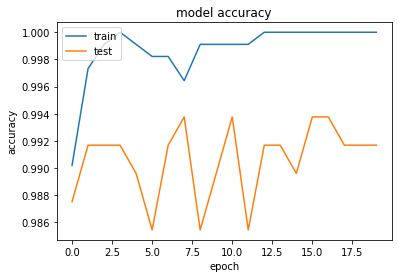

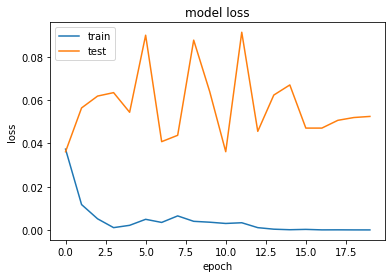

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping



from keras.optimizers import SGD,Adam,RMSprop,Adadelta,Adagrad,Adamax
opt = Adamax()
#opt=keras.optimizers.rmsprop(lr=1,decay=1e-6)

model.compile(loss='binary_crossentropy', #2 class (not multiple class)
              optimizer=opt,
              metrics=['accuracy'])

early_stop=EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
#print(model.summary())

weight_name="drive/2class_weight.hdf5"
checkpointer = ModelCheckpoint(filepath=weight_name, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

#validation_steps = 50 or len(x_test)
#validation_data = test_datagen.flow(x_test,y_test)
#steps_per_epoch = 118, shuffle=true

#validation_data=(x_test, y_test)
#history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=64),callbacks=[checkpointer],validation_data = test_datagen.flow(x_test,y_test)
                            #,epochs=20)

history=model.fit(x_train,y_train,batch_size=32,callbacks=[checkpointer,early_stop],validation_data=(x_test, y_test),epochs=20)

model.save("drive/AlexNet_2class_Adam.h5")



import matplotlib.pyplot as plt
# Plot Accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[ 66   2]
 [  1 412]]


Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        68
           1       1.00      1.00      1.00       413

    accuracy                           0.99       481
   macro avg       0.99      0.98      0.99       481
weighted avg       0.99      0.99      0.99       481



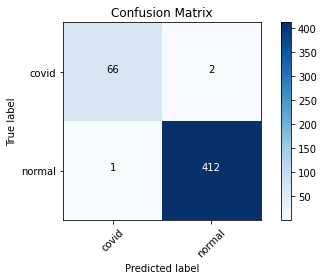

In [ ]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


model.load_weights(weight_name)

y_predicted =  model.predict_classes(x_test)
#print(y_predicted)

#print(y_test)

y_true = np.argmax(y_test, axis=1)
#print(y_true)


from sklearn.metrics import confusion_matrix


classes=['covid', 'normal']


cm=confusion_matrix(y_true, y_predicted,labels=[0,1])

print(cm)
print("\n")





#plot confusion matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, classes)


from sklearn.metrics import classification_report


print(classification_report(y_true, y_predicted))

No handles with labels found to put in legend.


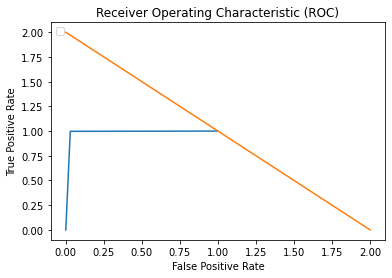

In [ ]:
#Roc curve
from sklearn.metrics import roc_curve



import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# y-expected output ve ypred_prediction

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predicted)
roc_auc=auc(fpr_keras,tpr_keras)

plt.figure()
plt.plot(fpr_keras, tpr_keras,thresholds_keras)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")

plt.legend(loc='upper left')

plt.show()
